In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def create_results(filename):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(filename)
    
    return df

In [26]:
def plot_cyclegg_results(df):
    # Filter rows with "Valid" result
    valid_results = df[df['result'] == 'Valid']

    # Create time_range variable
    time_range = np.arange(0, 10.1 * 1000, 0.1 * 1000)  # Range from 0 to 300 seconds in 100ms increments
    
    # Initialize num_valid_at_time variable
    num_valid_at_time = []
    
    # Iterate over time_range and count the number of valid results for each time step
    for t in time_range:
        num_valid = valid_results[valid_results['time'] <= t].shape[0]
        num_valid_at_time.append(num_valid)



    # Creating subplots with a 2x1 grid
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    # Plotting the data for the first 2 seconds
    ax1.plot(time_range, num_valid_at_time)
    ax1.set_xlim(0, 1000)  # Limiting x-axis to the first 2 seconds
    
    # Plotting the data for the rest of the time
    ax2.plot(time_range, num_valid_at_time)
    ax2.set_xlim(1000, 10000)  # Limiting x-axis to 2 to 60 seconds
    
    # Adjusting tick labels for the first subplot
    # ax1.set_xticks([i for i in range(0, 2001, 10)])  # Granularity of 0.01 seconds
    
    # Adding labels and title
    fig.text(0.5, 0.04, 'Time (seconds)', ha='center')
    fig.text(0.04, 0.5, 'Data', va='center', rotation='vertical')
    fig.suptitle('Data vs Time')
    
    # Adjusting layout to prevent overlap
    plt.tight_layout()
    
    # Displaying the plot
    plt.show()
    
    # Plot 1: time versus name for Valid results
    plt.figure(figsize=(8, 6))
    plt.plot(time_range, num_valid_at_time)
    # Zooming in on the first 2 seconds
    plt.gca().set_aspect(2/10)
    plt.xlabel('Time (ms)')
    plt.ylabel('Count')
    plt.title('Time versus count for Valid Results')
    plt.show()
    
    # Plot 2: num_lemmas_attempted versus name for all rows
    # plt.figure(figsize=(8, 6))
    # plt.scatter(df['name'],df['num_lemmas_attempted'])
    # plt.xlabel('Name')
    # plt.ylabel('Number of Lemmas Attempted')
    # plt.title('Number of Lemmas Attempted versus Name')
    # plt.gca().axes.get_xaxis().set_visible(False)  # Hide the name axis
    # plt.show()

In [143]:
def zoomed_in_cactus_plot(filtered_times, tool_names, title, end_zoom_range=1, zoom_scale=0.002, end_range=10, regular_scale=0.01):
    '''
    Takes in a list of times
    and makes a cactus plot for them which is zoomed in on 1s.
    '''
    
    # Generate times
    times_first_segment = np.arange(0, end_zoom_range, zoom_scale)
    times_second_segment = np.arange(end_zoom_range, end_range, regular_scale)
    times = np.concatenate((times_first_segment, times_second_segment))
    
    # Iterate over time_range and count the number of valid results for each time step
    for i, time_data in enumerate(filtered_times):
        num_valid_at_time = []
        for t in times:
            num_valid = time_data[time_data <= t].shape[0]
            num_valid_at_time.append(num_valid)
        plt.plot(range(len(num_valid_at_time)), num_valid_at_time, label = tool_names[i])

    # print(list(zip(times, num_valid_at_time)))
    # print([f'{times[i]}ms' for i in range(0, len(times), len(times) // 10)])
    
    # Plot
    plt.xlabel('Time')
    plt.ylabel('# Benchmarks')
    plt.xticks(ticks=np.arange(0, len(times), len(times) // 10), labels=[f'{times[i]:.1f}s' for i in range(0, len(times), len(times) // 10)])

    # Add vertical line at the point where the time scale changes
    plt.axvline(len(times_first_segment), color='gray', linestyle='--')
    
    # Annotate the plot to indicate the transition
    plt.annotate('Time scale changes', xy=(len(times_first_segment), 0), xytext=(len(times_first_segment) + 100, 0.5),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.legend()
    plt.title(title)
    plt.show()

In [102]:
def filter_clam_results(clam_results, name_column, name_prefix, results_to_keep, name_suffix='', ignore_missing=False):
    '''
    Filters a dataframe containing clam results to only those
    that require lemmas.
    '''
    # Create a new list result_names by prepending name_prefix to results_to_keep
    result_names = [name_prefix + str(result) + name_suffix for result in results_to_keep]

    # Filter clam_results to keep only results where name_column is contained in results_to_keep
    filtered_results = clam_results[clam_results[name_column].isin(result_names)]

    # for result in result_names:
    #     if not any(result == clam_results[name_column]):
    #         print(result)
    if not ignore_missing:
        assert(len(filtered_results) == 50)

    return filtered_results

In [192]:
def plot_scatter(results_1, results_2, tool_1, tool_2, result_1_limit=None, result_2_limit=None, axis='time'):
    if result_1_limit is None:
        result_1_limit = results_1[axis].max()
    if result_2_limit is None:
        result_2_limit = results_2[axis].max()
    
    # Assuming results_1 and results_2 are your DataFrames
    # Merge the DataFrames on 'name' column
    merged_df = results_1.merge(results_2, on='name', suffixes=('_1', '_2'))
    
    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    
    # Define marker styles and colors based on result column
    marker_styles = {
        (False, False): {'marker': '+', 'color': 'blue'},   # Both False
        (True, False): {'marker': '*', 'color': 'green'},   # results_1 True, results_2 False
        (False, True): {'marker': 'x', 'color': 'red'},     # results_1 False, results_2 True
        (True, True): {'marker': 'o', 'color': 'black'}        # All other cases
    }
    
    for index, row in merged_df.iterrows():
        result_1 = row['result_1']
        result_2 = row['result_2']
        marker_style = marker_styles[(result_1, result_2)]
        plt.scatter(row[axis + '_1'], row[axis + '_2'], marker=marker_style['marker'], color=marker_style['color'], label=f"Result: {result_1}, {result_2}")

    plt.xlim(0, result_1_limit)
    plt.ylim(0, result_2_limit)
    # Add labels and legend
    plt.xlabel(f'{axis} in {tool_1}')
    plt.ylabel(f'{axis} in {tool_2}')
    plt.title(f'Scatter Plot of {axis} in {tool_1} vs {axis} in {tool_2}')

    # Adding a dashed diagonal line
    plt.plot([0, result_1_limit], [0, result_2_limit], 'k--')
    
    # Adding legend with custom markers and colors
    legend_handles = []
    prove_result_to_str = lambda res: 'Proves' if res else 'Fails'
    for (result_1, result_2), label in marker_styles.items():
        legend_handles.append(plt.Line2D([0], [0], marker=label['marker'], color=label['color'],
                                         label=f"{tool_1} {prove_result_to_str(result_1)}, {tool_2} {prove_result_to_str(result_2)}"))
    plt.legend(handles=legend_handles)
    
    # Show plot
    plt.grid(True)
    plt.show()

In [125]:
def cyclegg_valid_times(cyclegg_df):
    return cyclegg_df[cyclegg_df['result'] == 'Valid']['time'] / 1000

In [126]:
def hipspec_valid_times(hipspec_df):
    return hipspec_df[hipspec_df['prop_proven']]['time']

In [130]:
def thesy_valid_times(thesy_df):
    return thesy_df[thesy_df['success']]['time']

In [133]:
def cvc4_valid_times(cvc4_df):
    return cvc4_df[cvc4_df['result'] == 'success']['time'].map(lambda t: float(t.rstrip(' ms')) / 1000)

In [159]:
def cyclegg_normalize_df(cyclegg_df, prefix):
    norm_df = cyclegg_df.copy()
    norm_df['name'] = cyclegg_df['name'].str[len(prefix):]
    norm_df['result'] = cyclegg_df['result'] == 'Valid'
    norm_df['time'] = cyclegg_df['time'] / 1000
    return norm_df

In [207]:
def hipspec_normalize_df(hipspec_df, prefix='./'):
    norm_df = hipspec_df.copy()
    # remove leading 0s as well as the prefix
    norm_df['name'] = hipspec_df['prop_name'].str[len(prefix):].str.lstrip('0')
    norm_df['result'] = hipspec_df['prop_proven']
    # num_lemmas already exists but it isn't the same
    norm_df['num_lemmas'] = hipspec_df['num_lemmas_attempted']
    norm_df['num_lemmas_proven'] = hipspec_df['num_proved_lemmas']
    return norm_df

In [3]:
# Range from 1 to 35 inclusive
range1 = map(str, range(1, 36))
# Handle the case where there's a prefix 0 (hacky, I know)
range_single_digit = map(lambda x: '0' + str(x), range(1,10))
# Range from 48 to 50 inclusive
range2 = map(str, range(48, 51))
# Range from 75 to 86 inclusive
range3 = map(str, range(75, 87))

# Combine all ranges
clam_lemma_props = list(range_single_digit) + list(range1) + list(range2) + list(range3)
len(clam_lemma_props)

59

In [197]:
cyclegg_results_clam = create_results("./results-clam-5s.csv")
cyclegg_results_clam_lemma_props = filter_clam_results(cyclegg_results_clam, 'name', 'clam_', clam_lemma_props)
# time data for the props which were valid among the lemma props
cyclegg_clam_props_valid_times = cyclegg_valid_times(cyclegg_results_clam_lemma_props)

In [196]:
hipspec_results_clam = create_results("./hipspec-results-clam.csv")
hipspec_results_clam_lemma_props = filter_clam_results(hipspec_results_clam, 'prop_name', './', clam_lemma_props)
hipspec_clam_lemma_props_valid_times = hipspec_valid_times(hipspec_results_clam_lemma_props)

In [131]:
thesy_results = create_results("./thesy-results-from-paper.csv")
thesy_results_clam = thesy_results[thesy_results['test_suite'] == 'clam']
thesy_results_clam_lemma_props = filter_clam_results(thesy_results_clam, 'file_name', 'goal', clam_lemma_props, name_suffix='.smt2.stats.json', ignore_missing=True)
thesy_clam_lemma_props_valid_times = thesy_valid_times(thesy_results_clam_lemma_props)

In [134]:
cvc4_results_clam = create_results("./cvc4-ig-results-clam.csv")
cvc4_results_clam_lemma_props = filter_clam_results(cvc4_results_clam, 'name', 'goal', clam_lemma_props, name_suffix='.smt2')
cvc4_clam_lemma_props_valid_times = cvc4_valid_times(cvc4_results_clam_lemma_props)

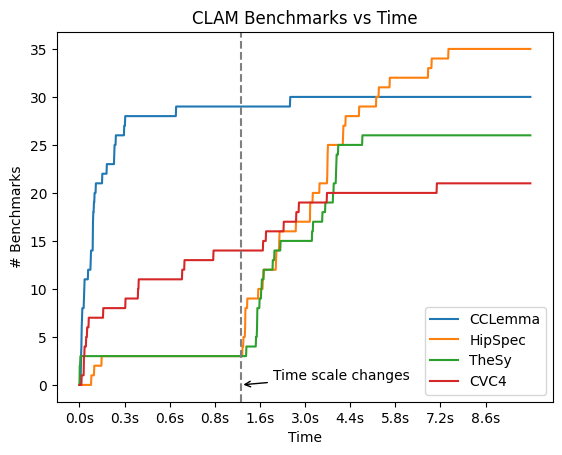

In [135]:
zoomed_in_cactus_plot([cyclegg_clam_props_valid_times, hipspec_clam_lemma_props_valid_times, thesy_clam_lemma_props_valid_times, cvc4_clam_lemma_props_valid_times],
                      ['CCLemma', 'HipSpec', 'TheSy', 'CVC4'],
                      'CLAM Benchmarks vs Time')

In [137]:
cyclegg_results_isa = create_results("./results-isaplanner-5s.csv")
cyclegg_isa_valid_times = cyclegg_valid_times(cyclegg_results_isa)

In [139]:
hipspec_results_isa = create_results("./hipspec-results-isaplanner.csv")
hipspec_isa_valid_times = hipspec_valid_times(hipspec_results_isa)

In [140]:
thesy_results = create_results("./thesy-results-from-paper.csv")
thesy_results_isa = thesy_results[thesy_results['test_suite'] == 'isaplanner']
thesy_isa_valid_times = thesy_valid_times(thesy_results_isa)

In [141]:
cvc4_results_isa = create_results("./cvc4-ig-results-isaplanner.csv")
cvc4_isa_valid_times = cvc4_valid_times(cvc4_results_isa)

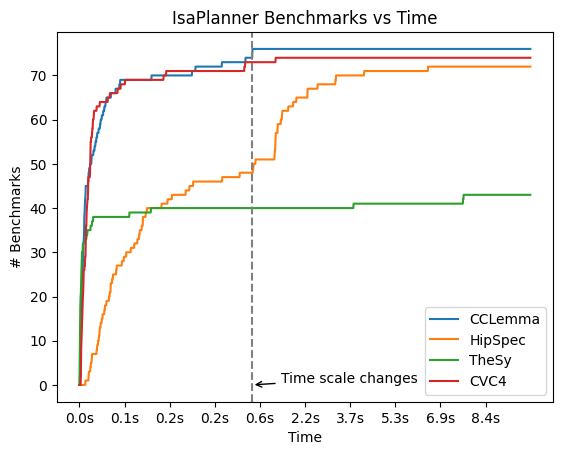

In [148]:
zoomed_in_cactus_plot([cyclegg_isa_valid_times, hipspec_isa_valid_times, thesy_isa_valid_times, cvc4_isa_valid_times],
                      ['CCLemma', 'HipSpec', 'TheSy', 'CVC4'],
                      'IsaPlanner Benchmarks vs Time',
                      end_zoom_range=0.3, zoom_scale=0.0005, end_range=10)

In [198]:
cyclegg_results_clam_lemma_props_norm = cyclegg_normalize_df(cyclegg_results_clam_lemma_props, 'clam_')
# cyclegg_results_clam_lemma_props_norm

In [208]:
hipspec_results_clam_lemma_props_norm = hipspec_normalize_df(hipspec_results_clam_lemma_props)

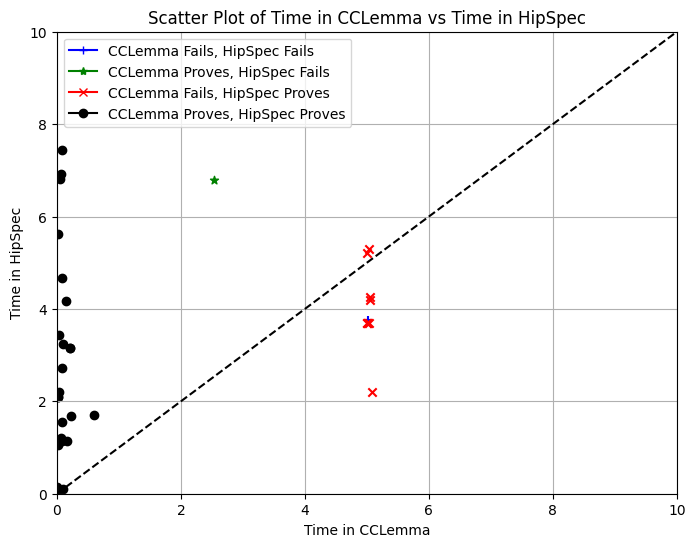

In [187]:
plot_scatter(cyclegg_results_clam_lemma_props_norm, hipspec_results_clam_lemma_props_norm, 'CCLemma', 'HipSpec', 10, 10)

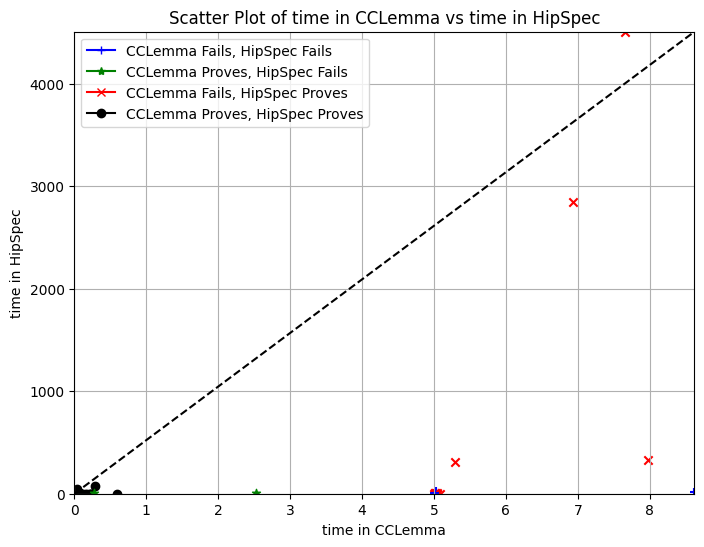

In [202]:
plot_scatter(cyclegg_results_clam_lemma_props_norm, hipspec_results_clam_lemma_props_norm, 'CCLemma', 'HipSpec')

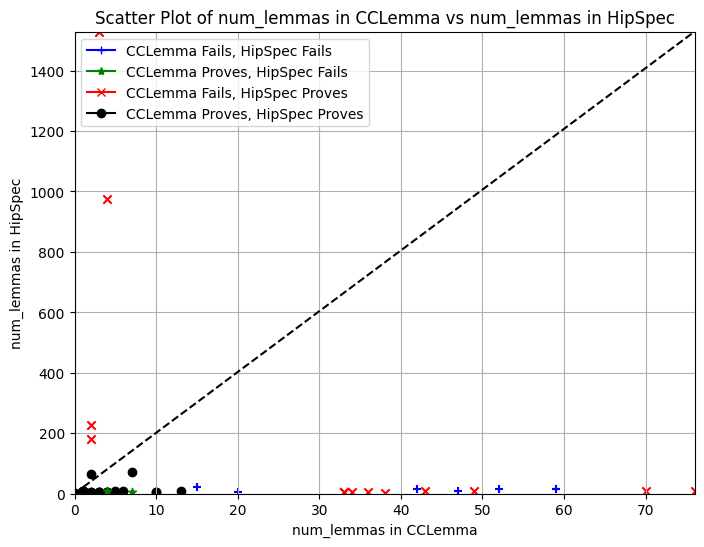

In [203]:
plot_scatter(cyclegg_results_clam_lemma_props_norm, hipspec_results_clam_lemma_props_norm, 'CCLemma', 'HipSpec', axis='num_lemmas')

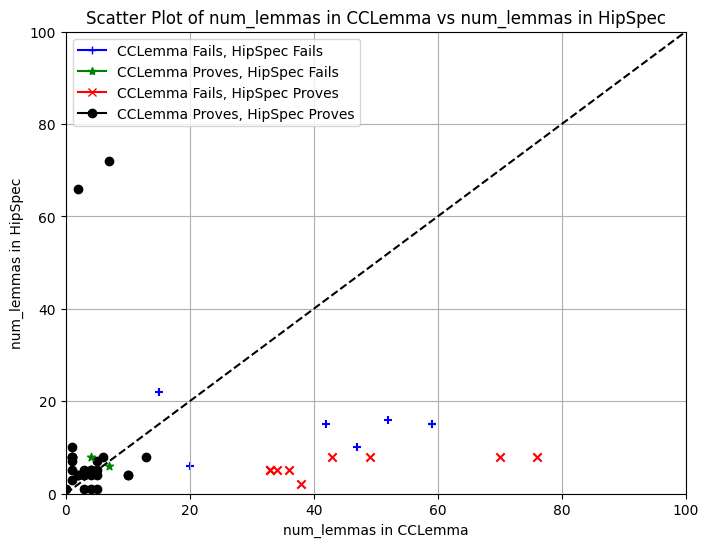

In [204]:
plot_scatter(cyclegg_results_clam_lemma_props_norm, hipspec_results_clam_lemma_props_norm, 'CCLemma', 'HipSpec', 100, 100, axis='num_lemmas')

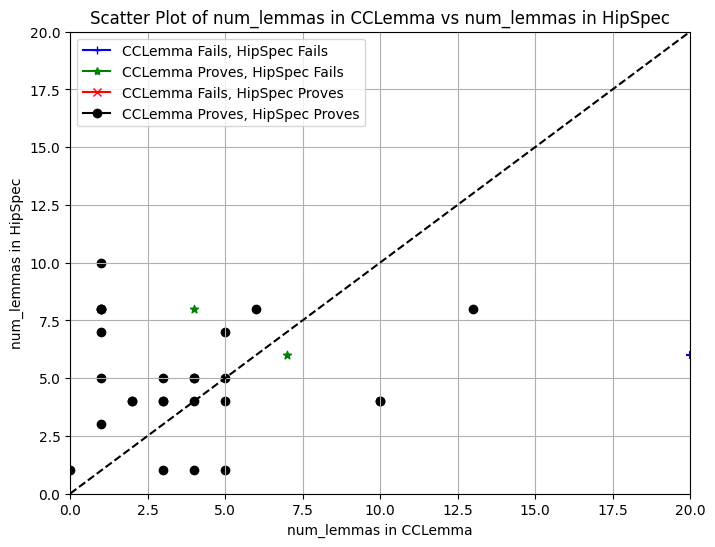

In [205]:
plot_scatter(cyclegg_results_clam_lemma_props_norm, hipspec_results_clam_lemma_props_norm, 'CCLemma', 'HipSpec', 20, 20, axis='num_lemmas')

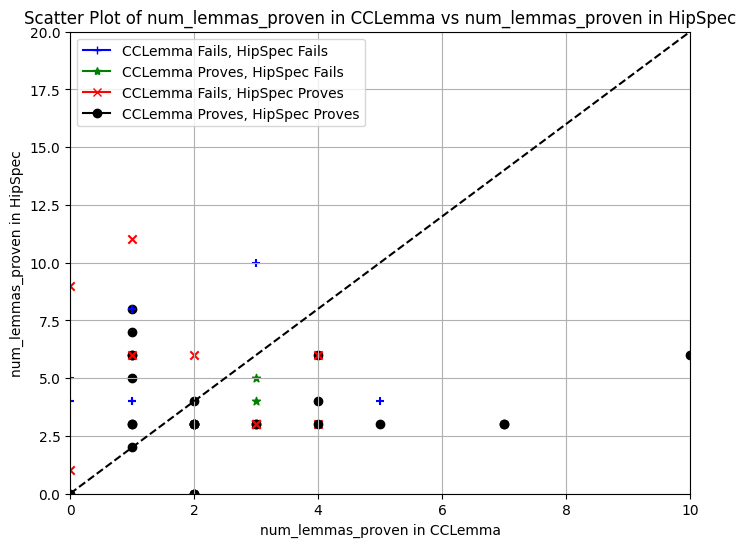

In [212]:
plot_scatter(cyclegg_results_clam_lemma_props_norm, hipspec_results_clam_lemma_props_norm, 'CCLemma', 'HipSpec', 10, 20, axis='num_lemmas_proven')